In [1]:
import pathlib

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from transforms import transforms

IMG_DIR = pathlib.Path("images/")

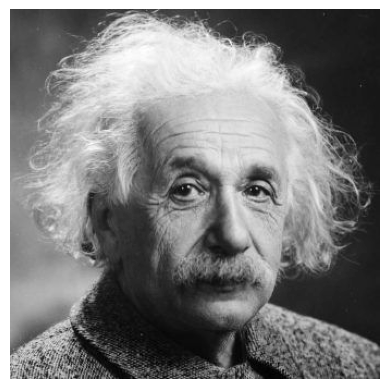

In [42]:
img = cv2.imread(str(IMG_DIR / "Albert_Einstein.jpg"), cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

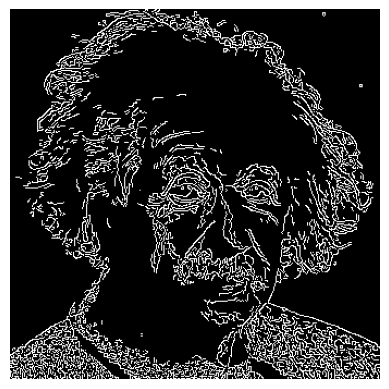

In [44]:
canny = cv2.Canny(img, 100, 150)
plt.imshow(canny, cmap="gray")
plt.axis("off")
plt.show()

In [45]:
x, y = 0, 0
sigma = 1

v = 1 / (2 * np.pi * sigma**2) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
v

0.15915494309189535

In [46]:
def get_gaussian_filter(kernel, sigma):
    x, y = np.mgrid[-kernel // 2 + 1 : kernel // 2 + 1, -kernel // 2 + 1 : kernel // 2 + 1]
    return 1 / (2 * np.pi * sigma**2) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

In [47]:
gaussian_filter = get_gaussian_filter(3, 1)
gaussian_filter

array([[0.05854983, 0.09653235, 0.05854983],
       [0.09653235, 0.15915494, 0.09653235],
       [0.05854983, 0.09653235, 0.05854983]])

In [48]:
gaussian_filter.sum()

0.7794836797093876

In [49]:
np.meshgrid(np.arange(-1, 2), np.arange(-1, 2))

[array([[-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1]]),
 array([[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]])]

In [50]:
np.mgrid[-1:2, -1:2]

array([[[-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[-1,  0,  1],
        [-1,  0,  1],
        [-1,  0,  1]]])

In [51]:
a = cv2.getGaussianKernel(3, 1)
a @ a.T  # type: ignore

array([[0.07511361, 0.1238414 , 0.07511361],
       [0.1238414 , 0.20417996, 0.1238414 ],
       [0.07511361, 0.1238414 , 0.07511361]])

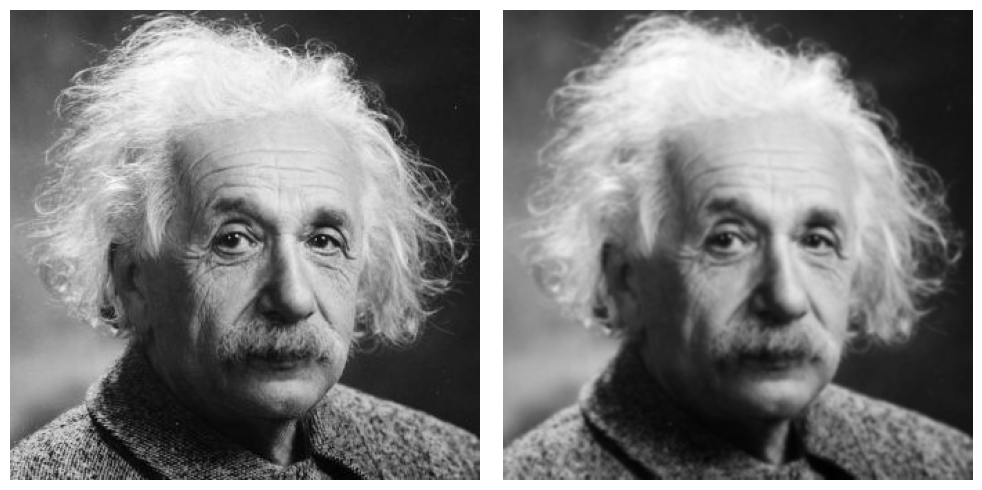

In [52]:
gaussian_filter = get_gaussian_filter(11, 1)
img_smooth = cv2.filter2D(img, -1, gaussian_filter)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
ax1.imshow(img, cmap="gray")
ax1.axis("off")
ax2.imshow(img_smooth, cmap="gray")
ax2.axis("off")
plt.show()

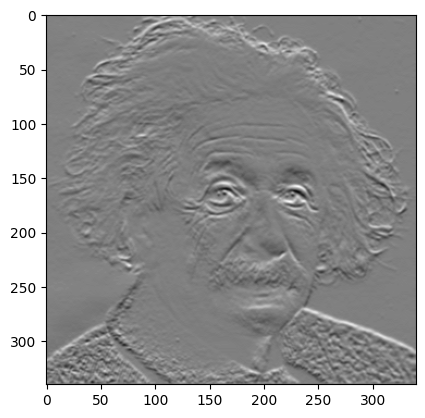

In [53]:
img_smooth = img_smooth.astype(np.float32)
mask_x = np.array([[-1.0], [1.0]])
mask_y = mask_x.transpose()

ix = cv2.filter2D(img_smooth, -1, mask_x)
iy = cv2.filter2D(img_smooth, -1, mask_y)

plt.imshow(ix, cmap="gray")
plt.show()

In [54]:
def get_dx_gaussian_filter(kernel, sigma):
    x, y = np.mgrid[-kernel // 2 + 1 : kernel // 2 + 1, -kernel // 2 + 1 : kernel // 2 + 1]
    return -x / (2 * np.pi * sigma**4) * np.exp(-(x**2 + y**2) / (2 * sigma**2))


def get_dy_gaussian_filter(kernel, sigma):
    x, y = np.mgrid[-kernel // 2 + 1 : kernel // 2 + 1, -kernel // 2 + 1 : kernel // 2 + 1]
    return -y / (2 * np.pi * sigma**4) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

In [55]:
dx = get_dx_gaussian_filter(3, 0.5)
dy = get_dy_gaussian_filter(3, 0.5)

In [56]:
dx

array([[ 0.04664039,  0.34462847,  0.04664039],
       [ 0.        ,  0.        ,  0.        ],
       [-0.04664039, -0.34462847, -0.04664039]])

In [57]:
dy

array([[ 0.04664039,  0.        , -0.04664039],
       [ 0.34462847,  0.        , -0.34462847],
       [ 0.04664039,  0.        , -0.04664039]])

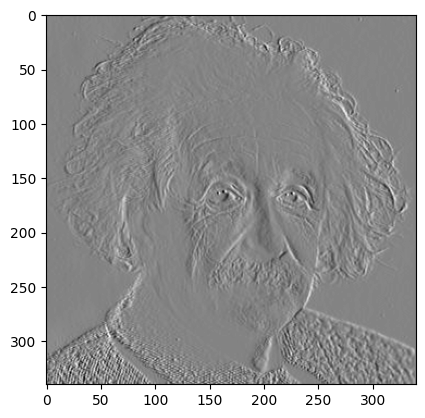

In [58]:
img = img.astype(np.float32)
ix = cv2.filter2D(img, -1, dx)
iy = cv2.filter2D(img, -1, dy)

plt.imshow(iy, cmap="gray")
plt.show()

In [59]:
gradient_magnitude = np.sqrt(ix**2 + iy**2)  # type: ignore
gradient_direction = np.rad2deg(np.arctan2(iy, ix))


In [60]:
gradient_magnitude.min(), gradient_magnitude.max()

(1.0536712e-08, 81.7327)

In [61]:
gradient_direction.min(), gradient_direction.max()

(-180.0, 180.0)

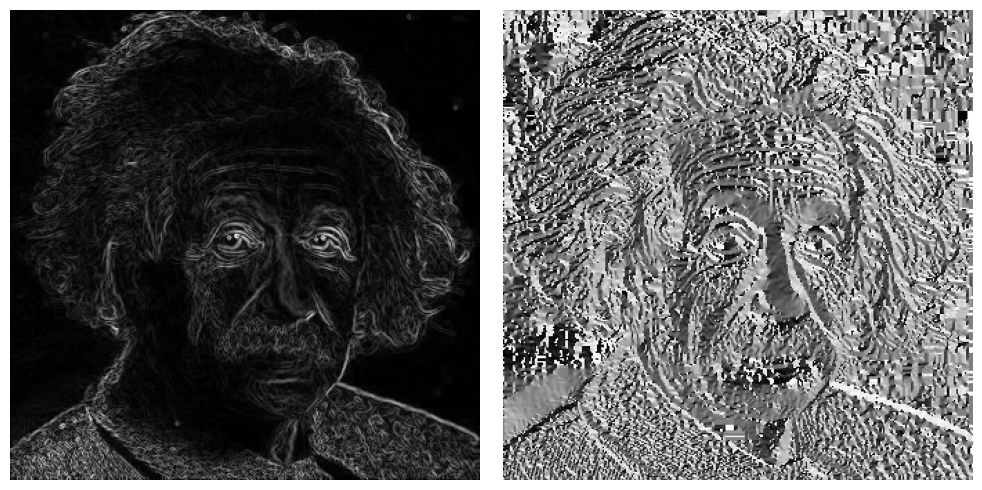

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
ax1.imshow(gradient_magnitude, cmap="gray")
ax1.axis("off")
ax2.imshow(gradient_direction, cmap="gray")
ax2.axis("off")
plt.show()

In [64]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    M, N = gradient_magnitude.shape
    output = np.zeros_like(gradient_magnitude)
    PI = 180
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            direction = gradient_direction[i, j]
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            else:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]
            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                output[i, j] = gradient_magnitude[i, j]
    return output

In [65]:
gradient_magnitude_suppressed = non_max_suppression(gradient_magnitude, gradient_direction)

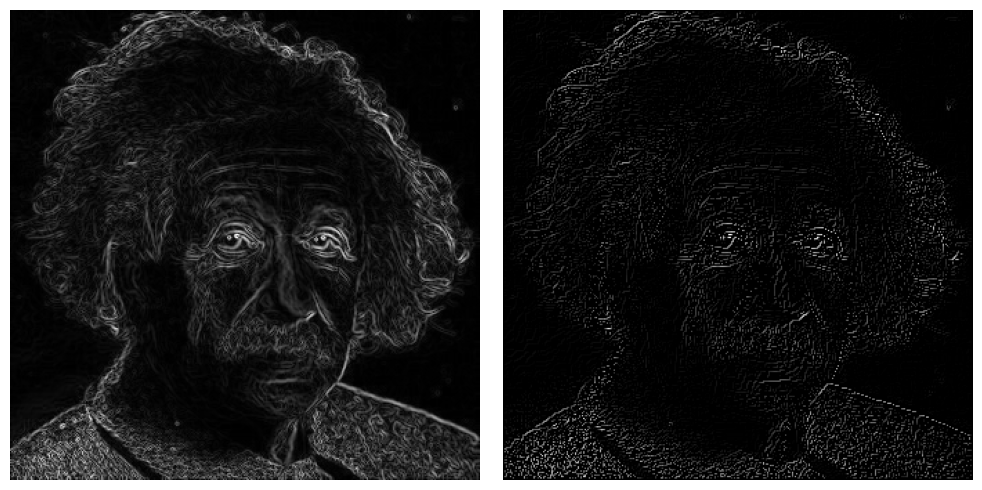

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
ax1.imshow(gradient_magnitude, cmap="gray")
ax1.axis("off")
ax2.imshow(gradient_magnitude_suppressed, cmap="gray")
ax2.axis("off")
plt.show()

In [73]:
def histeresis_thresholding(gradient_magnitude_suppressed, low, high):
    output = np.zeros_like(gradient_magnitude_suppressed)
    weak, strong = 25, 255
    strong_i, strong_j = np.where(gradient_magnitude_suppressed >= high)
    weak_i, weak_j = np.where(
        (gradient_magnitude_suppressed <= high) & (gradient_magnitude_suppressed >= low)
    )
    output[strong_i, strong_j] = strong
    output[weak_i, weak_j] = weak
    return output

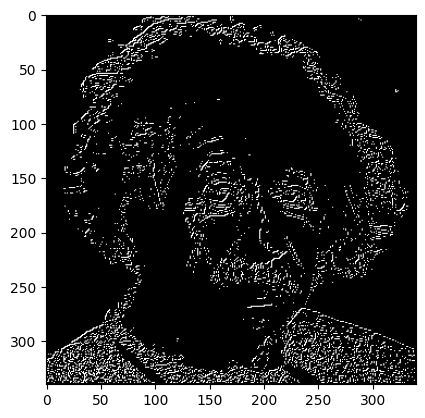

In [86]:
histeresis = histeresis_thresholding(gradient_magnitude_suppressed, 15, 100)
plt.imshow(histeresis, cmap="gray")
plt.show()